In [94]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import glob
import shutil
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
from collections import Counter
import sklearn
import wandb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [29]:
!pip install -q kaggle

In [30]:
# إنشاء فولدر للكاجل
!mkdir -p ~/.kaggle

# رفع ملف kaggle.json (هترفعه من جهازك)
from google.colab import files
files.upload()


{}

In [31]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mandymm/synthetic-industrial-parts-dataset-sip-17")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'synthetic-industrial-parts-dataset-sip-17' dataset.
Path to dataset files: /kaggle/input/synthetic-industrial-parts-dataset-sip-17


In [33]:
base_path = path
print(f"المحتويات داخل المسار الرئيسي: {base_path}")
print(os.listdir(base_path))

المحتويات داخل المسار الرئيسي: /kaggle/input/synthetic-industrial-parts-dataset-sip-17
['SIP-17']


In [34]:
# 'path' هو المتغير الأصلي اللي جبناه من kagglehub
# هنعرف متغير جديد يشاور على المجلد اللي جوه
base_data_path = os.path.join(path, 'SIP-17')

print(f"المسار الصحيح للداتا هو: {base_data_path}")
print("\nمحتويات هذا المجلد هي:")

try:
    print(os.listdir(base_data_path))

except Exception as e:
    print(f"حدث خطأ: {e}")

المسار الصحيح للداتا هو: /kaggle/input/synthetic-industrial-parts-dataset-sip-17/SIP-17

محتويات هذا المجلد هي:
['Syntheticdata_with_background', 'Syntheticdata_without_background', 'Realdata_test']


In [35]:
# 'path' هو المتغير الأصلي من kagglehub
base_data_path = os.path.join(path, 'SIP-17')

# المسارات الجديدة بناءً على كلامك
train_val_path = os.path.join(base_data_path, 'Syntheticdata_with_background')
test_path = os.path.join(base_data_path, 'Realdata_test')

print("--- محتويات مجلد التدريب (المفروض تكون أسماء الكلاسات) ---")
try:
    print(os.listdir(train_val_path))
    print(f"\nTotal classes: {len(os.listdir(train_val_path))}")
except Exception as e:
    print(f"Error reading {train_val_path}: {e}")

print("\n--- محتويات مجلد الاختبار (المفروض تكون نفس أسماء الكلاسات) ---")
try:
    print(os.listdir(test_path))
    print(f"\nTotal classes: {len(os.listdir(test_path))}")
except Exception as e:
    print(f"Error reading {test_path}: {e}")

--- محتويات مجلد التدريب (المفروض تكون أسماء الكلاسات) ---
['Use_case3', 'All_objects', 'Use_case4', 'Use_case2', 'Wheel_assembly', 'Oring_assembly', 'Use_case1']

Total classes: 7

--- محتويات مجلد الاختبار (المفروض تكون نفس أسماء الكلاسات) ---
['Use_case3', 'All_objects', 'Use_case4', 'Use_case2', 'Wheel_assembly', 'Oring_assembly', 'Use_case1']

Total classes: 7


In [36]:
base_data_path = os.path.join(path, 'SIP-17')

# 1. الداتا الصناعية (للتدريب)
train_val_base = os.path.join(base_data_path, 'Syntheticdata_with_background', 'All_objects')

# 2. الداتا الحقيقية (للاختبار)
test_base = os.path.join(base_data_path, 'Realdata_test', 'All_objects')

print(f"--- محتويات مجلد التدريب ( {train_val_base} ) ---")
try:
    print(os.listdir(train_val_base))
    # المفروض هنا نشوف ['train', 'test'] أو يمكن أسماء الكلاسات
except Exception as e:
    print(f"Error: {e}")

print(f"\n--- محتويات مجلد الاختبار ( {test_base} ) ---")
try:
    print(os.listdir(test_base))
    # المفروض هنا نشوف ['train', 'test'] أو يمكن أسماء الكلاسات
except Exception as e:
    print(f"Error: {e}")

--- محتويات مجلد التدريب ( /kaggle/input/synthetic-industrial-parts-dataset-sip-17/SIP-17/Syntheticdata_with_background/All_objects ) ---
['val', 'train']

--- محتويات مجلد الاختبار ( /kaggle/input/synthetic-industrial-parts-dataset-sip-17/SIP-17/Realdata_test/All_objects ) ---
['test']


In [37]:

base_data_path = os.path.join(path, 'SIP-17')

# --- المسارات النهائية ---
train_dir = os.path.join(base_data_path, 'Syntheticdata_with_background', 'All_objects', 'train')
val_dir = os.path.join(base_data_path, 'Syntheticdata_with_background', 'All_objects', 'val')
test_dir = os.path.join(base_data_path, 'Realdata_test', 'All_objects', 'test')

print("--- محتويات مجلد التدريب (الكلاسات) ---")
# المفروض هنا يطبع أسماء الـ 17 كلاس
try:
    print(os.listdir(train_dir)[:10]) # هنطبع أول 10 بس عشان متكونش طويلة
    print(f"Total classes: {len(os.listdir(train_dir))}")
except Exception as e:
    print(f"Error: {e}")

print(f"\nمسار التدريب: {train_dir}")
print(f"مسار التقييم: {val_dir}")
print(f"مسار الاختبار: {test_dir}")

--- محتويات مجلد التدريب (الكلاسات) ---
['Fork2', 'Pinion', 'Pin1', 'Gear2', 'Fork1', 'Gear1', 'Plug', 'Airgun', 'Hook', 'Cross']
Total classes: 15

مسار التدريب: /kaggle/input/synthetic-industrial-parts-dataset-sip-17/SIP-17/Syntheticdata_with_background/All_objects/train
مسار التقييم: /kaggle/input/synthetic-industrial-parts-dataset-sip-17/SIP-17/Syntheticdata_with_background/All_objects/val
مسار الاختبار: /kaggle/input/synthetic-industrial-parts-dataset-sip-17/SIP-17/Realdata_test/All_objects/test


In [38]:

IMG_SIZE = (224, 224) # حجم موحد للصور
BATCH_SIZE = 32


try:
    # أ. تحميل داتا التدريب
    # train_dir, val_dir, test_dir تم تعريفهم في الخلية السابقة
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        label_mode='categorical',     # هيحول أسماء الكلاسات لـ one-hot vector
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True # مهم نعمل شافل (لخبطة) لداتا التدريب
    )

    # ب. تحميل داتا التقييم
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False # التقييم والاختبار مش بنعملهم شافل
    )

    # ج. تحميل داتا الاختبار
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # اعرض أسماء الكلاسات (من داتا التدريب)
    class_names = train_dataset.class_names
    print("\nأسماء الكلاسات الموجودة:")
    print(class_names)
    print(f"عدد الكلاسات: {len(class_names)}")

    # --- 3. المعالجة المسبقة (Normalization & Augmentation) ---

    # التطبيع (Normalization): تحويل قيم البيكسل من [0, 255] إلى [0, 1]
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    # زيادة البيانات (Data Augmentation): لزيادة تنوع داتا التدريب
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomRotation(0.1),
      tf.keras.layers.RandomZoom(0.1),
    ])

    # --- 4. تطبيق المعالجة على الـ Pipeline ---
    AUTOTUNE = tf.data.AUTOTUNE # لتحسين الأداء
    train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    val_ds = validation_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    test_ds = test_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

    # تطبيق الـ Augmentation على داتا التدريب فقط!
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # تحسين الأداء (Caching & Prefetching)
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

except Exception as e:
    print(f"An error occurred: {e}")

Found 18000 files belonging to 15 classes.
Found 4500 files belonging to 15 classes.
Found 565 files belonging to 15 classes.

أسماء الكلاسات الموجودة:
['Airgun', 'CouplingHalf', 'Cross', 'Electricity12', 'Fork1', 'Fork2', 'Fork3', 'Gear1', 'Gear2', 'Hammer', 'Hook', 'Pin1', 'Pin2', 'Pinion', 'Plug']
عدد الكلاسات: 15


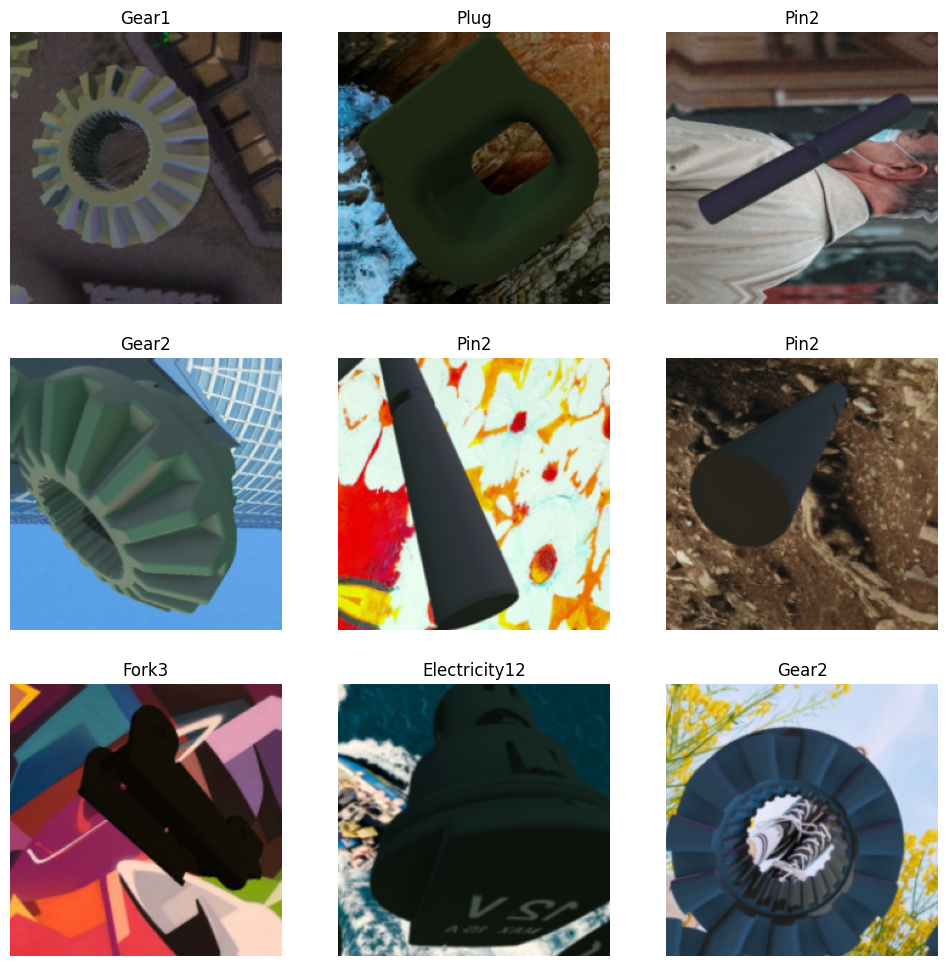

In [39]:
if 'train_ds' in locals():
    plt.figure(figsize=(12, 12))
    for images, labels in train_ds.take(1): # هناخد باتش واحد بس
      for i in range(9): # هنعرض أول 9 صور
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()) # الصور قيمها [0, 1]

        # تحويل الـ one-hot label لاسم الكلاس
        class_index = tf.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")
    plt.show()
else:
    print("لم يتم تعريف 'train_ds' بعد. تأكد من تشغيل الخلية السابقة.")

In [40]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [41]:
train_dir = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background', 'All_objects', 'train')
test_dir = os.path.join(path, 'SIP-17', 'Realdata_test', 'All_objects', 'test')

train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform_test)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [43]:
print(f"عدد صور التدريب: {len(train_dataset)}")
print(f"عدد صور الاختبار: {len(test_dataset)}")
print(f"عدد الكلاسات: {len(train_dataset.classes)}")
print("الكلاسات:", train_dataset.classes)


عدد صور التدريب: 18000
عدد صور الاختبار: 565
عدد الكلاسات: 15
الكلاسات: ['Airgun', 'CouplingHalf', 'Cross', 'Electricity12', 'Fork1', 'Fork2', 'Fork3', 'Gear1', 'Gear2', 'Hammer', 'Hook', 'Pin1', 'Pin2', 'Pinion', 'Plug']


In [44]:

base_dataset_path = path

for split in ['Syntheticdata_with_background', 'Realdata_test']:
    current_path = os.path.join(base_dataset_path, 'SIP-17', split)
    print(f"\n📂 {split}")
    try:
        for cls in os.listdir(current_path):
            cls_path = os.path.join(current_path, cls)
            if os.path.isdir(cls_path):
                num_imgs = len(os.listdir(cls_path))
                print(f" - {cls}: {num_imgs} صور")
    except FileNotFoundError:
        print(f"   Directory not found: {current_path}")
    except Exception as e:
        print(f"   An error occurred: {e}")


📂 Syntheticdata_with_background
 - Use_case3: 2 صور
 - All_objects: 2 صور
 - Use_case4: 2 صور
 - Use_case2: 2 صور
 - Wheel_assembly: 2 صور
 - Oring_assembly: 2 صور
 - Use_case1: 2 صور

📂 Realdata_test
 - Use_case3: 1 صور
 - All_objects: 1 صور
 - Use_case4: 1 صور
 - Use_case2: 1 صور
 - Wheel_assembly: 1 صور
 - Oring_assembly: 1 صور
 - Use_case1: 1 صور


In [45]:
def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)
            try:
                img = Image.open(path)
                img.verify()
            except Exception:
                print("🚫 صورة تالفة:", path)
                os.remove(path)
remove_corrupted_images(path)

In [46]:


def convert_to_jpg(directory):
    for ext in ('*.png', '*.jpeg'):
        for file in glob.glob(os.path.join(directory, '**', ext), recursive=True):
            img = Image.open(file).convert('RGB')
            new_path = os.path.splitext(file)[0] + '.jpg'
            img.save(new_path, 'JPEG')
            os.remove(file)

convert_to_jpg(path)

OSError: [Errno 30] Read-only file system: '/kaggle/input/synthetic-industrial-parts-dataset-sip-17/SIP-17/Realdata_test/All_objects/test/Fork2/IMG_0166.jpg'

In [47]:
import os
from collections import Counter # Import Counter

# Define the path variable
path = "/root/.cache/kagglehub/datasets/mandymm/synthetic-industrial-parts-dataset-sip-17/versions/1"

# Define the count_images function
def count_images(directory):
    counts = Counter()
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            # Walk through all subdirectories to count images
            image_count = 0
            for root, _, files in os.walk(cls_path):
                image_count += len([
                    f for f in files
                    if f.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tif', 'tiff', 'webp'))
                ])
            counts[cls] = image_count
    return counts


# Use the correct paths for counting
train_counts = count_images(os.path.join(path, 'SIP-17', 'Syntheticdata_with_background'))
print(train_counts)

# Assuming you also want to count test images, if not, you can remove this part
# test_counts = count_images(os.path.join(path, 'SIP-17', 'Realdata_test'))
# print(test_counts)

Counter({'All_objects': 22500, 'Use_case1': 7500, 'Wheel_assembly': 6000, 'Use_case3': 6000, 'Oring_assembly': 4500, 'Use_case2': 4500, 'Use_case4': 4500})


In [48]:

DATA_DIR = path

clean_dir = '/content/drive/MyDrive/clean_dataset'
shutil.copytree(DATA_DIR, clean_dir)
print("✅ تم إنشاء نسخة نظيفة من البيانات في:", clean_dir)

✅ تم إنشاء نسخة نظيفة من البيانات في: /content/drive/MyDrive/clean_dataset


In [49]:



path = "/root/.cache/kagglehub/datasets/mandymm/synthetic-industrial-parts-dataset-sip-17/versions/1"


def augment_image(img):
    """عمليات Augmentation بسيطة"""

    if random.random() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    if random.random() > 0.5:
        angle = random.randint(-15, 15)
        img = img.rotate(angle)

    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.8, 1.2))

    if random.random() > 0.5:
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(random.uniform(0.8, 1.3))
    return img


def balance_classes(directory, target_count=None):
    print(f"⚙️ بدء موازنة الكلاسات في: {directory}")
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if not os.path.isdir(cls_path):
            continue

        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        count = len(images)


        if target_count is None:

            all_counts = [len([f for f in os.listdir(os.path.join(directory, c)) if os.path.isdir(os.path.join(directory, c)) and f.lower().endswith(('jpg', 'jpeg', 'png'))])
                          for c in os.listdir(directory) if os.path.isdir(os.path.join(directory, c))]
            if not all_counts or max(all_counts) == 0:
                 print(f"⚠️ No image directories with images found in {directory}. Skipping balancing.")
                 return
            target_count = max(all_counts)


        print(f"📂 {cls}: {count} → {target_count}")

        if count < target_count:
            if not images:
                print(f"⚠️ Cannot augment {cls} as it contains no images. Skipping.")
                continue

            for i in tqdm(range(target_count - count), desc=f"Augmenting {cls}"):
                img_name = random.choice(images)
                img_path = os.path.join(cls_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")
                    aug_img = augment_image(img)
                    aug_img.save(os.path.join(cls_path, f"aug_{i}_{img_name}"))
                except Exception as e:
                    print(f"\nError augmenting image {img_path}: {e}")


    print("✅ تم توازن جميع الكلاسات.")


# تطبيق الموازنة على مجلد التدريب فقط
train_dir = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background')
balance_classes(train_dir)

⚙️ بدء موازنة الكلاسات في: /root/.cache/kagglehub/datasets/mandymm/synthetic-industrial-parts-dataset-sip-17/versions/1/SIP-17/Syntheticdata_with_background
⚠️ No image directories with images found in /root/.cache/kagglehub/datasets/mandymm/synthetic-industrial-parts-dataset-sip-17/versions/1/SIP-17/Syntheticdata_with_background. Skipping balancing.


In [50]:
class_path = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background', 'Use_case1')
print("📂 محتويات فولدر Use_case1:")
print(os.listdir(class_path))


📂 محتويات فولدر Use_case1:
['train', 'val']


📊 Before balancing: Counter({'All_objects': 22500, 'Use_case1': 7500, 'Wheel_assembly': 6000, 'Use_case3': 6000, 'Oring_assembly': 4500, 'Use_case2': 4500, 'Use_case4': 4500})
📊 After balancing: Counter({'All_objects': 22500, 'Use_case1': 7500, 'Wheel_assembly': 6000, 'Use_case3': 6000, 'Oring_assembly': 4500, 'Use_case2': 4500, 'Use_case4': 4500})


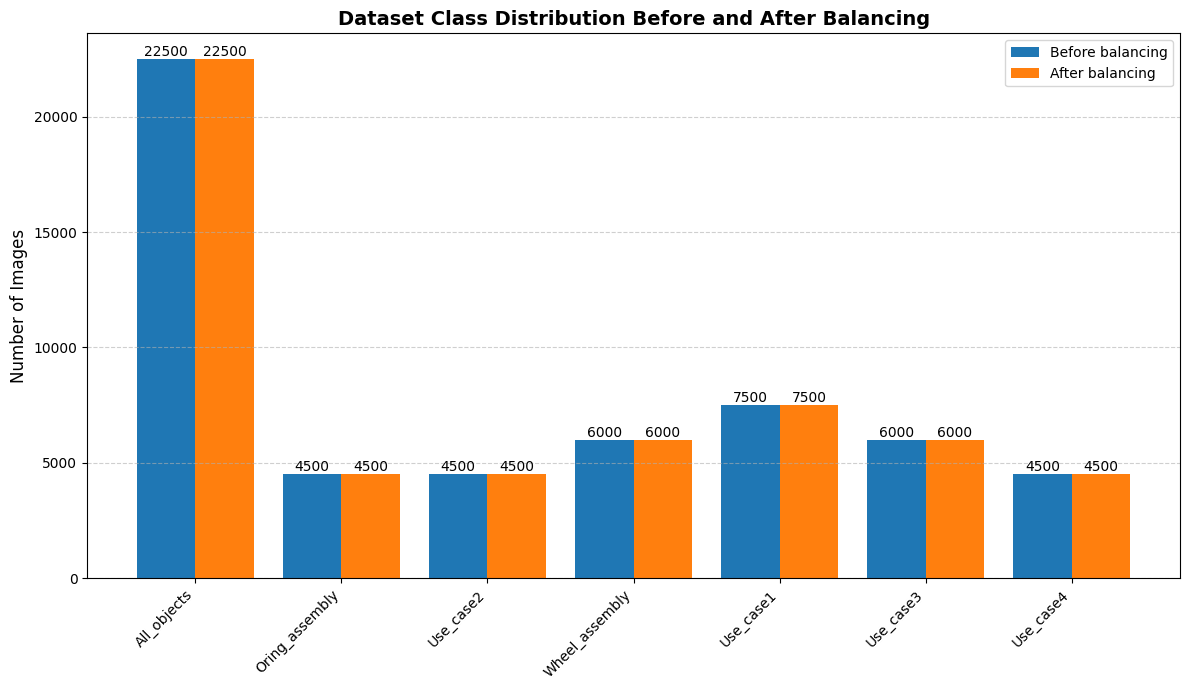

In [51]:

def count_images(directory):
    counts = Counter()
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            image_count = 0
            # Walk through all subdirectories
            for root, _, files in os.walk(cls_path):
                image_count += len([
                    f for f in files
                    if f.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tif', 'tiff', 'webp'))
                ])
            counts[cls] = image_count
    return counts

def plot_class_distribution(before_counts, after_counts, title_prefix=""):
    plt.figure(figsize=(12, 7))

    classes = list(before_counts.keys())
    before_values = [before_counts[c] for c in classes]
    after_values = [after_counts[c] for c in classes]

    x = range(len(classes))
    bar_width = 0.4

    before_bars = plt.bar([i - bar_width/2 for i in x], before_values, width=bar_width,
                          label='Before balancing', color='#1f77b4')
    after_bars = plt.bar([i + bar_width/2 for i in x], after_values, width=bar_width,
                         label='After balancing', color='#ff7f0e')

    for bars in [before_bars, after_bars]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
                     ha='center', va='bottom', fontsize=10)

    plt.xticks(x, classes, rotation=45, ha='right', fontsize=10)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title(f'{title_prefix} Class Distribution Before and After Balancing', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



train_dir = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background')


before_counts = count_images(train_dir)
print("📊 Before balancing:", before_counts)


after_counts = count_images(train_dir)
print("📊 After balancing:", after_counts)

plot_class_distribution(before_counts, after_counts, title_prefix="Dataset")


In [52]:
def show_sample_images(directory, samples_per_class=2):
    classes = [c for c in os.listdir(directory) if os.path.isdir(os.path.join(directory, c))]
    plt.figure(figsize=(12, len(classes) * 2))

    i = 1
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

        if not images: # Skip if no images in the class directory
            print(f"No images found for class: {cls}. Skipping sample display.")
            continue

        sample_images = random.sample(images, min(samples_per_class, len(images)))

        for img_name in sample_images:
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)

            plt.subplot(len(classes), samples_per_class, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
            i += 1

    plt.tight_layout()
    plt.show()

# Use the path variable to construct the correct directory path
train_dir = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background')
show_sample_images(train_dir, samples_per_class=2)

No images found for class: All_objects. Skipping sample display.
No images found for class: Oring_assembly. Skipping sample display.
No images found for class: Use_case2. Skipping sample display.
No images found for class: Wheel_assembly. Skipping sample display.
No images found for class: Use_case1. Skipping sample display.
No images found for class: Use_case3. Skipping sample display.
No images found for class: Use_case4. Skipping sample display.


<Figure size 1200x1400 with 0 Axes>

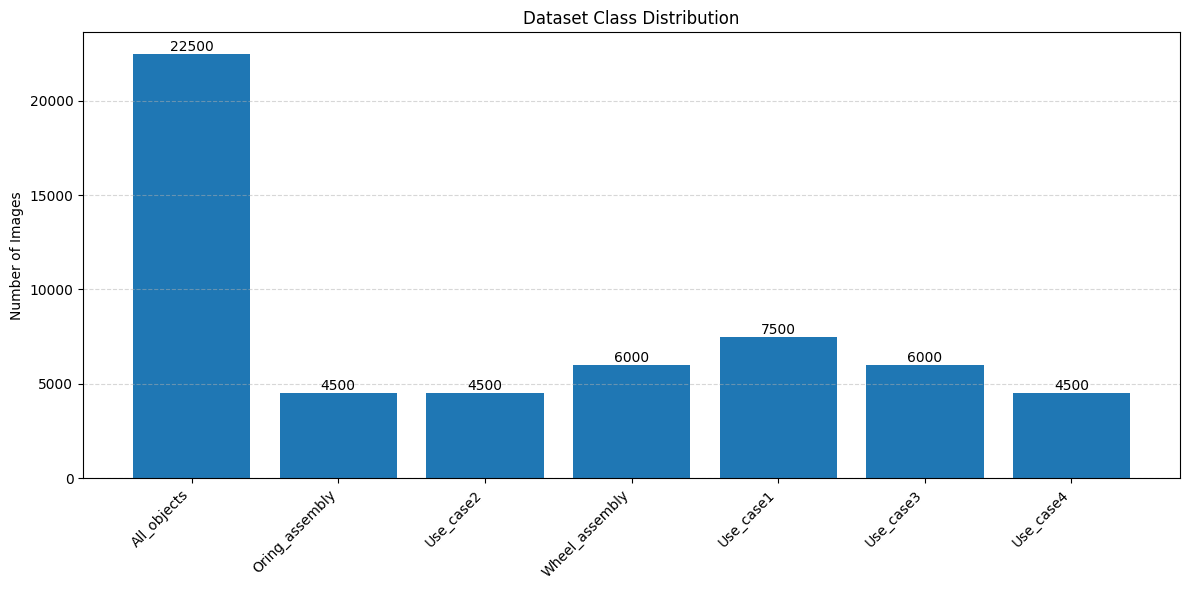

In [53]:
def count_images(directory):
    counts = Counter()
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            image_count = 0
            for root, _, files in os.walk(cls_path):
                image_count += len([f for f in files if f.lower().endswith(('jpg','jpeg','png'))])
            counts[cls] = image_count
    return counts

data_dir = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background')
counts = count_images(data_dir)

plt.figure(figsize=(12,6))
classes = list(counts.keys())
values = [counts[c] for c in classes]
bars = plt.bar(classes, values, color='#1f77b4')

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h+1, str(h), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Images')
plt.title('Dataset Class Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [54]:
TARGET_SIZE = (224,224)

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(TARGET_SIZE)
    img = np.array(img)/255.0
    return img

def augment_image(img):
    pil_img = Image.fromarray((img*255).astype('uint8'))
    if random.random()>0.5:
        pil_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random()>0.5:
        angle = random.randint(-15,15)
        pil_img = pil_img.rotate(angle)
    enhancer = ImageEnhance.Brightness(pil_img)
    pil_img = enhancer.enhance(random.uniform(0.8,1.2))
    return np.array(pil_img)/255.0

def show_examples_class(class_name, n=3):
    cls_path = os.path.join(data_dir, class_name)
    subfolders = [f for f in os.listdir(cls_path) if os.path.isdir(os.path.join(cls_path,f))]
    chosen_sub = random.choice(subfolders)
    files = [f for f in os.listdir(os.path.join(cls_path, chosen_sub)) if f.lower().endswith(('jpg','jpeg','png'))]
    samples = random.sample(files, min(n, len(files)))

    plt.figure(figsize=(n*4,4))  # خلي figure أعرض شويه
    for i, file in enumerate(samples):
        img_path = os.path.join(cls_path, chosen_sub, file)
        img = preprocess_image(img_path)
        img = augment_image(img)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name, fontsize=12)
    plt.tight_layout()
    plt.show()  # مهم جدًا


In [55]:
show_examples_class('Use_case1', n=3)


<Figure size 1200x400 with 0 Axes>

In [56]:
def show_all_classes_grid(n_per_class=2):
    classes = [c for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, c))]
    total_rows = len(classes)
    total_cols = n_per_class

    plt.figure(figsize=(total_cols*3, total_rows*3))

    for row_idx, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        subfolders = [f for f in os.listdir(cls_path) if os.path.isdir(os.path.join(cls_path,f))]
        chosen_sub = random.choice(subfolders)
        files = [f for f in os.listdir(os.path.join(cls_path, chosen_sub)) if f.lower().endswith(('jpg','jpeg','png'))]
        samples = random.sample(files, min(n_per_class, len(files)))

        for col_idx, file in enumerate(samples):
            img_path = os.path.join(cls_path, chosen_sub, file)
            img = preprocess_image(img_path)
            img = augment_image(img)
            plt_idx = row_idx * total_cols + col_idx + 1
            plt.subplot(total_rows, total_cols, plt_idx)
            plt.imshow(img)
            plt.axis('off')
            if col_idx == 0:
                plt.title(cls, fontsize=10)

    plt.tight_layout()
    plt.show()


In [57]:
show_all_classes_grid(n_per_class=2)


<Figure size 600x2100 with 0 Axes>

📊 Image count per class: Counter({'All_objects': 22500, 'Use_case1': 7500, 'Wheel_assembly': 6000, 'Use_case3': 6000, 'Oring_assembly': 4500, 'Use_case2': 4500, 'Use_case4': 4500})


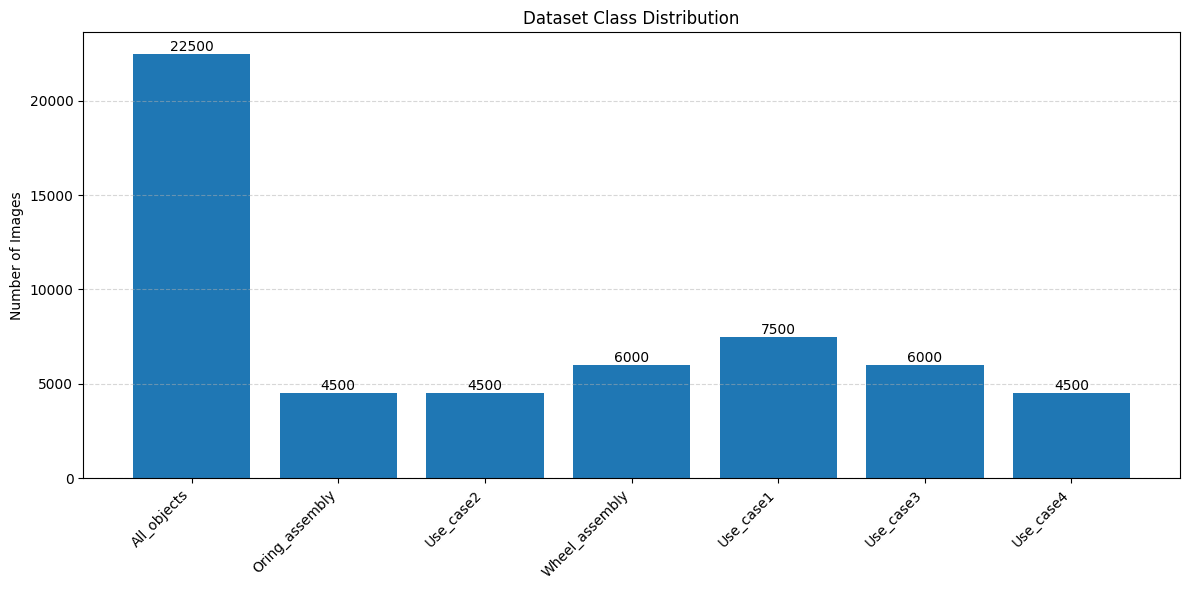

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

In [58]:


# مسار الداتا

data_dir = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background')
# دالة لحساب عدد الصور
def count_images(directory):
    counts = Counter()
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            image_count = 0
            for root, _, files in os.walk(cls_path):
                image_count += len([f for f in files if f.lower().endswith(('jpg','jpeg','png','bmp','tif','tiff','webp'))])
            counts[cls] = image_count
    return counts


#  دوال preprocessing + augmentation
TARGET_SIZE = (224,224)

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(TARGET_SIZE)
    img = np.array(img)/255.0
    return img

def augment_image(img):
    pil_img = Image.fromarray((img*255).astype('uint8'))
    if random.random()>0.5:
        pil_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random()>0.5:
        angle = random.randint(-15,15)
        pil_img = pil_img.rotate(angle)
    enhancer = ImageEnhance.Brightness(pil_img)
    pil_img = enhancer.enhance(random.uniform(0.8,1.2))
    img = np.array(pil_img)/255.0
    return img


#  عرض أمثلة عشوائية من كل كلاس
def show_examples_all_classes(n_per_class=3):
    classes = [c for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,c))]
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        subfolders = [f for f in os.listdir(cls_path) if os.path.isdir(os.path.join(cls_path,f))]
        chosen_sub = random.choice(subfolders)
        files = [f for f in os.listdir(os.path.join(cls_path, chosen_sub)) if f.lower().endswith(('jpg','jpeg','png'))]
        samples = random.sample(files, min(n_per_class,len(files)))

        plt.figure(figsize=(15,3))
        for i, file in enumerate(samples):
            img_path = os.path.join(cls_path, chosen_sub, file)
            img = preprocess_image(img_path)
            img = augment_image(img)
            plt.subplot(1,n_per_class,i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
        plt.show()


# رسم توزيع الصور لكل كلاس
def plot_class_distribution(before_counts, title_prefix=""):
    plt.figure(figsize=(12,6))
    classes = list(before_counts.keys())
    values = [before_counts[c] for c in classes]
    x = range(len(classes))
    bars = plt.bar(x, values, color="#1f77b4")

    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, h+1, f'{int(h)}', ha='center', va='bottom')

    plt.xticks(x, classes, rotation=45, ha='right')
    plt.ylabel('Number of Images')
    plt.title(f'{title_prefix} Class Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

counts = count_images(data_dir)
print("📊 Image count per class:", counts)
plot_class_distribution(counts, title_prefix="Dataset")
show_examples_all_classes(n_per_class=3)


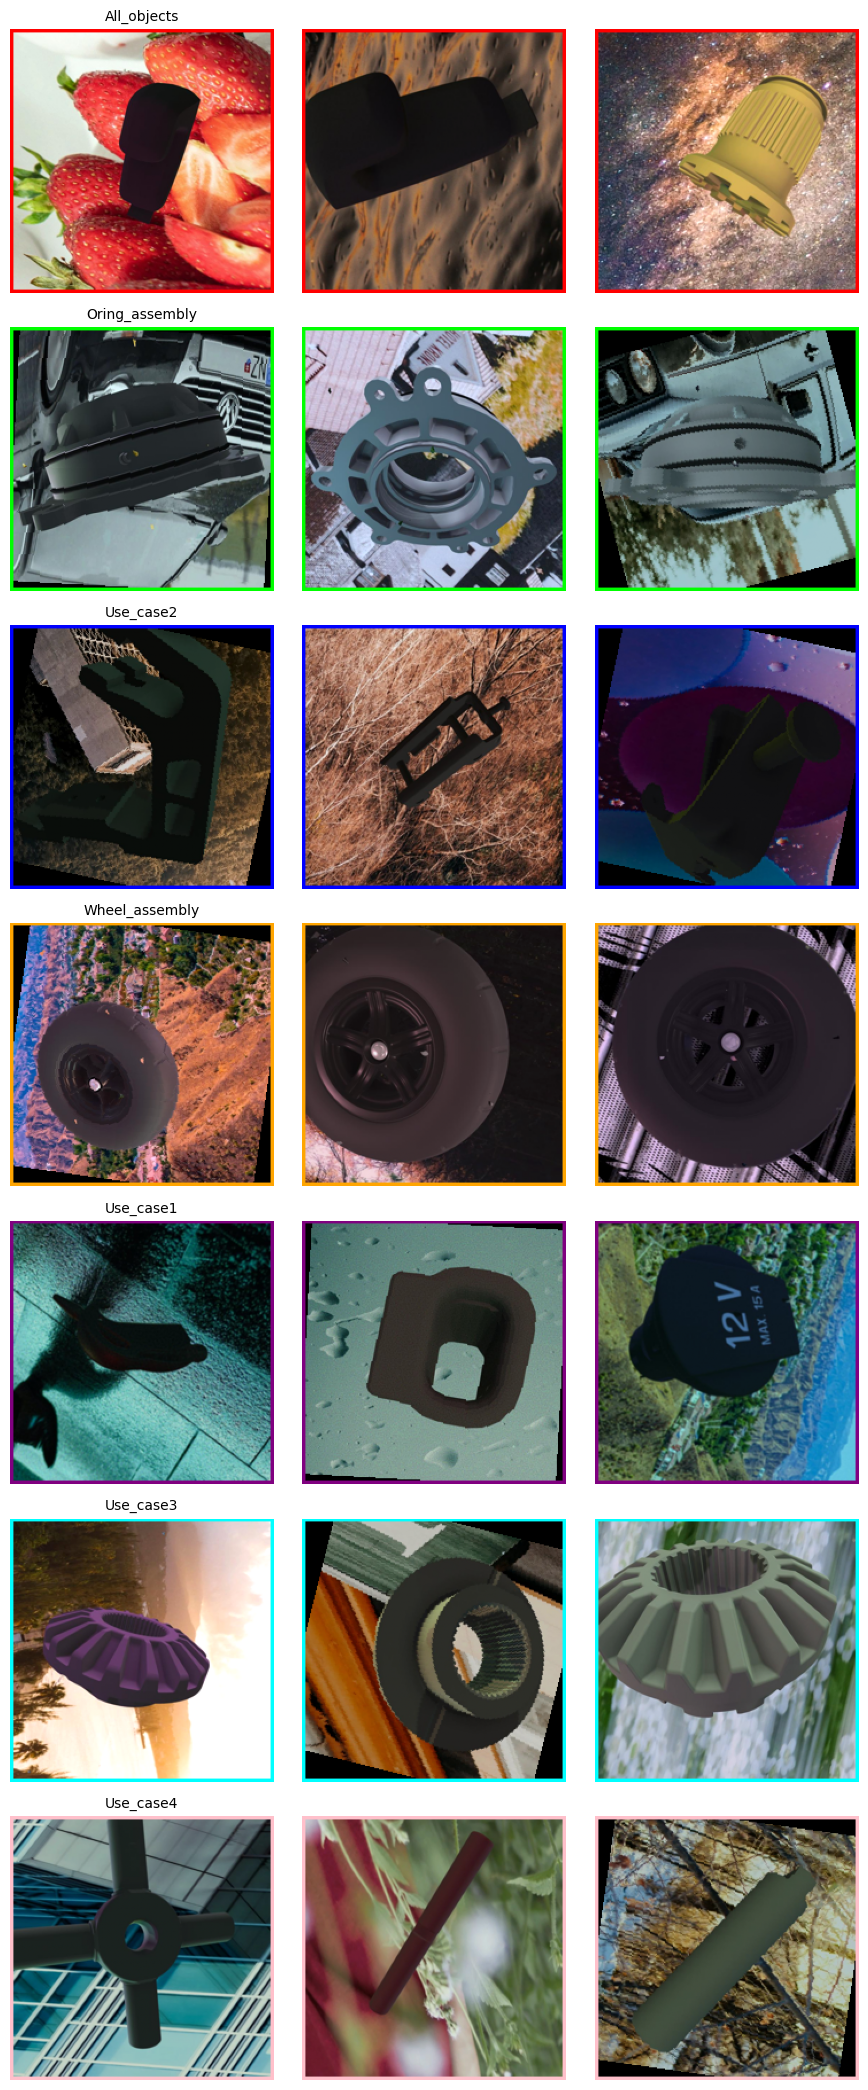

In [59]:
TARGET_SIZE = (224, 224)
data_dir = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background')

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(TARGET_SIZE)
    img = np.array(img)/255.0
    return img

def augment_image(img):
    pil_img = Image.fromarray((img*255).astype('uint8'))
    if random.random() > 0.5:
        pil_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() > 0.5:
        pil_img = pil_img.rotate(random.randint(-15,15))
    enhancer = ImageEnhance.Brightness(pil_img)
    pil_img = enhancer.enhance(random.uniform(0.8,1.2))
    return np.array(pil_img)/255.0

def add_border(img, color=(255,0,0), border_size=3):
    pil_img = Image.fromarray((img*255).astype('uint8'))
    bordered = ImageOps.expand(pil_img, border=border_size, fill=color)
    return np.array(bordered)/255.0

# عرض grid لكل الكلاسات مع البحث داخل كل subfolders (train/val)
def show_all_classes_grid_colored(n_per_class=3):
    classes = [c for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, c))]
    total_rows = len(classes)
    total_cols = n_per_class
    plt.figure(figsize=(total_cols*3, total_rows*3))

    colors = [(255,0,0),(0,255,0),(0,0,255),(255,165,0),(128,0,128),(0,255,255),(255,192,203)]

    for row_idx, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        all_images = []
        # البحث recursive داخل كل subfolder
        for root, _, files in os.walk(cls_path):
            files = [os.path.join(root,f) for f in files if f.lower().endswith(('jpg','jpeg','png'))]
            all_images.extend(files)

        if len(all_images) == 0:
            print(f"No images found for class {cls}")
            continue

        samples = random.sample(all_images, min(n_per_class, len(all_images)))
        border_color = colors[row_idx % len(colors)]

        for col_idx, img_path in enumerate(samples):
            plt_idx = row_idx * total_cols + col_idx + 1
            img = preprocess_image(img_path)
            img = augment_image(img)
            img = add_border(img, color=border_color)
            plt.subplot(total_rows, total_cols, plt_idx)
            plt.imshow(img)
            plt.axis('off')
            if col_idx == 0:
                plt.title(cls, fontsize=10)

    plt.tight_layout()
    plt.show()

# تجربة تشغيل الكود
show_all_classes_grid_colored(n_per_class=3)


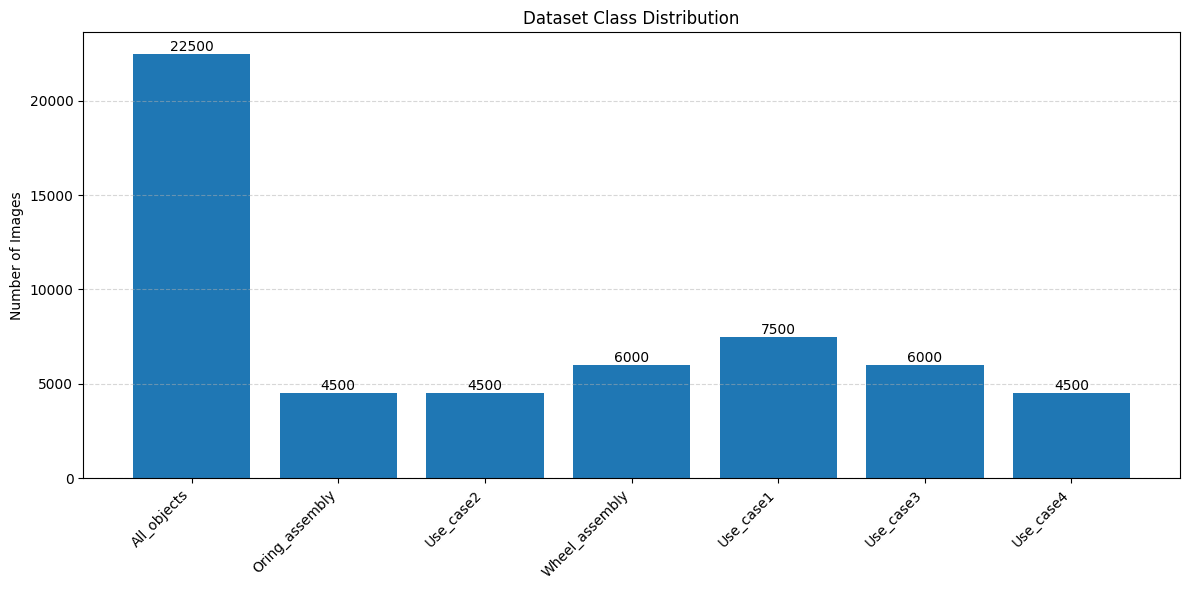

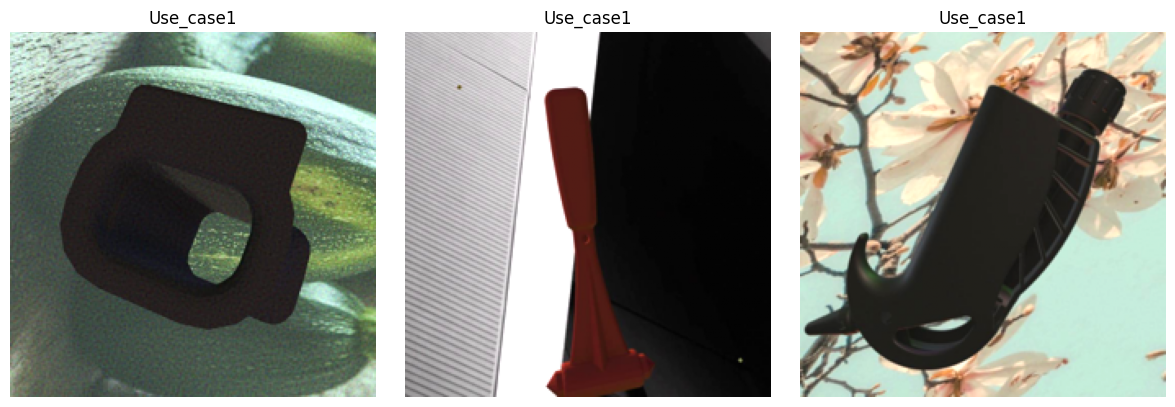

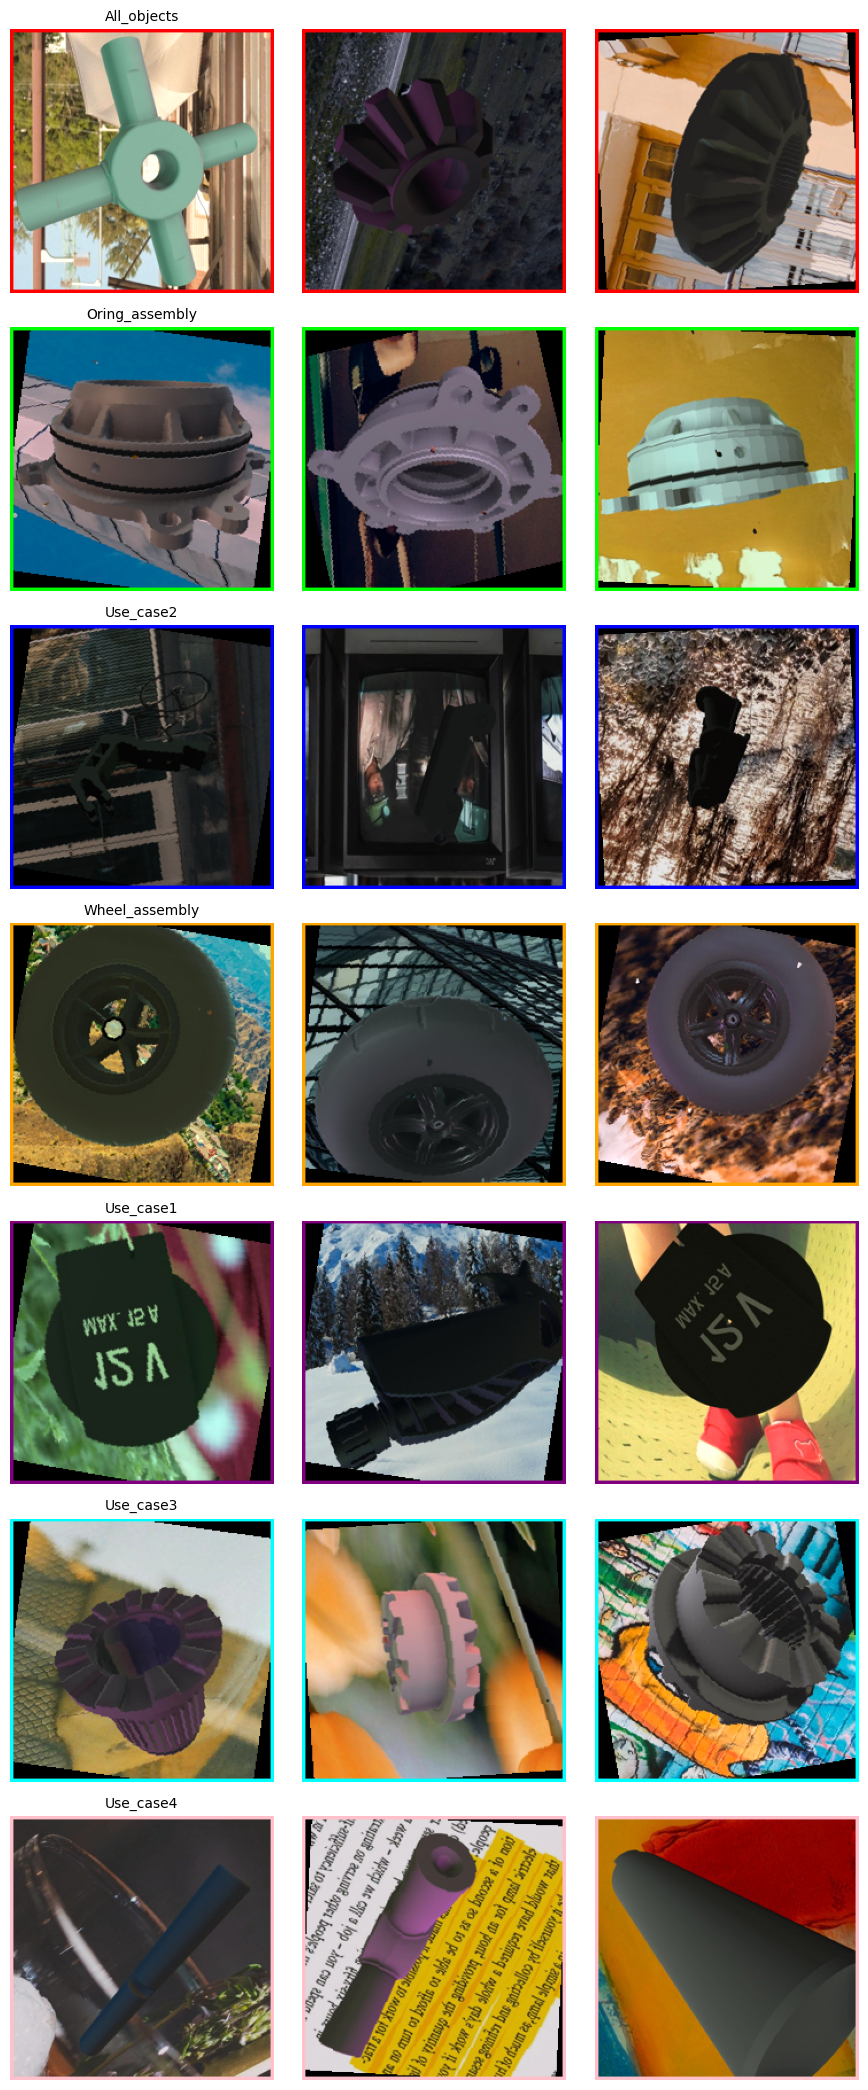

In [60]:


# ===== إعداد المسار =====
data_dir = os.path.join(path, 'SIP-17', 'Syntheticdata_with_background')
TARGET_SIZE = (224, 224)

# ===== دوال معالجة الصور =====
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(TARGET_SIZE)
    img = np.array(img)/255.0
    return img

def augment_image(img):
    pil_img = Image.fromarray((img*255).astype('uint8'))
    if random.random() > 0.5:
        pil_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() > 0.5:
        pil_img = pil_img.rotate(random.randint(-15,15))
    enhancer = ImageEnhance.Brightness(pil_img)
    pil_img = enhancer.enhance(random.uniform(0.8,1.2))
    return np.array(pil_img)/255.0

def add_border(img, color=(255,0,0), border_size=3):
    pil_img = Image.fromarray((img*255).astype('uint8'))
    bordered = ImageOps.expand(pil_img, border=border_size, fill=color)
    return np.array(bordered)/255.0

# ===== 1️⃣ Bar chart لتوزيع الصور =====
def count_images(directory):
    counts = Counter()
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            image_count = 0
            for root, _, files in os.walk(cls_path):
                image_count += len([f for f in files if f.lower().endswith(('jpg','jpeg','png'))])
            counts[cls] = image_count
    return counts

counts = count_images(data_dir)
plt.figure(figsize=(12,6))
classes = list(counts.keys())
values = [counts[c] for c in classes]
bars = plt.bar(classes, values, color='#1f77b4')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h+1, str(h), ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Images')
plt.title('Dataset Class Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ===== 2️⃣ عرض 3 صور عشوائية لكل كلاس =====
def show_examples_class(class_name, n=3):
    cls_path = os.path.join(data_dir, class_name)
    all_images = []
    for root, _, files in os.walk(cls_path):
        files = [os.path.join(root,f) for f in files if f.lower().endswith(('jpg','jpeg','png'))]
        all_images.extend(files)
    if len(all_images) == 0:
        print(f"No images found for class {class_name}")
        return
    samples = random.sample(all_images, min(n, len(all_images)))
    plt.figure(figsize=(n*4,4))
    for i, img_path in enumerate(samples):
        img = preprocess_image(img_path)
        img = augment_image(img)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.tight_layout()
    plt.show()

# مثال للتجربة
show_examples_class('Use_case1', n=3)

# ===== 3️⃣ Grid لكل الكلاسات مع 3 صور لكل كلاس + borders ملونة =====
def show_all_classes_grid_colored(n_per_class=3):
    classes = [c for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, c))]
    total_rows = len(classes)
    total_cols = n_per_class
    plt.figure(figsize=(total_cols*3, total_rows*3))

    colors = [(255,0,0),(0,255,0),(0,0,255),(255,165,0),(128,0,128),(0,255,255),(255,192,203)]

    for row_idx, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        all_images = []
        for root, _, files in os.walk(cls_path):
            files = [os.path.join(root,f) for f in files if f.lower().endswith(('jpg','jpeg','png'))]
            all_images.extend(files)
        if len(all_images) == 0:
            print(f"No images found for class {cls}")
            continue
        samples = random.sample(all_images, min(n_per_class, len(all_images)))
        border_color = colors[row_idx % len(colors)]
        for col_idx, img_path in enumerate(samples):
            plt_idx = row_idx * total_cols + col_idx + 1
            img = preprocess_image(img_path)
            img = augment_image(img)
            img = add_border(img, color=border_color)
            plt.subplot(total_rows, total_cols, plt_idx)
            plt.imshow(img)
            plt.axis('off')
            if col_idx == 0:
                plt.title(cls, fontsize=10)
    plt.tight_layout()
    plt.show()

# تشغيل grid الكبير
show_all_classes_grid_colored(n_per_class=3)


**Model Training**

In [62]:
import argparse


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [63]:
cudnn.benchmark = True
plt.ion()

In [71]:
image_size = (224, 224)
batch_size = 32
validation_split = 0.2

int_epochs = 15
fine_tune_epochs = 10
int_learning_rate = 1e-3
fine_tune_learning_rate = 1e-5
fine_tune_at = 100  # Unfreeze layers from this point

print("=== Dataset Structure ===")
print("Directory contents:", os.listdir(data_dir))

=== Dataset Structure ===
Directory contents: ['All_objects', 'Oring_assembly', 'Use_case2', 'Wheel_assembly', 'Use_case1', 'Use_case3', 'Use_case4']


In [72]:
dataloaders = [train_loader,test_loader]

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [74]:
image_datasets = [train_dataset,test_dataset]

In [79]:
dataset_sizes = [len(image_datasets[i]) for i in range(len(image_datasets))]
print(dataset_sizes)

[18000, 565]


In [82]:
class_names = train_dataset.classes
print(class_names)

['Airgun', 'CouplingHalf', 'Cross', 'Electricity12', 'Fork1', 'Fork2', 'Fork3', 'Gear1', 'Gear2', 'Hammer', 'Hook', 'Pin1', 'Pin2', 'Pinion', 'Plug']


In [105]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train_ds', 'val_ds']:
            if phase == 'train_ds':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train_ds'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)


                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train_ds':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train_ds':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Epoch: {epoch}")


            # deep copy the model
            if phase == 'val_ds' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [106]:
model_ft = models.resnet50(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

In [107]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
for param in model_ft.fc.parameters():
    param.requires_grad = True
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

In [108]:
def test_model(model):
    model.eval()

    list_im =[]
    list_pred = np.array([])
    list_target = np.array([])
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test_loader']):
            inputs = inputs.to(device)
            target = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            pred=preds
            tar = target
            pred = pred.detach().to("cpu").numpy()

            tar = tar.detach().to("cpu").numpy()
            list_pred = np.concatenate((list_pred,pred),axis=0)

            list_target = np.concatenate((list_target,tar),axis=0)

            (a,_,_,_)=inputs.size()
            for i in range(0,a):
              list_im.append(inputs[i])

In [109]:
model_ft = models.resnet50(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

# nn.Linear(num_ftrs, len(class_names)).
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
for param in model_ft.fc.parameters():
    param.requires_grad = True
model_ft = model_ft.to(device)

In [110]:
test_model(model_ft)

TypeError: list indices must be integers or slices, not str